# Importing Libraries

In [100]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, log_loss
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from hyperopt import hp, tpe, fmin, Trials, space_eval
import warnings
import shap

warnings.filterwarnings('ignore')
from Functions_George import read_txt_file


# Importing Data and clipping the "bad" looking ones

In [107]:
Data = pd.read_csv('features.csv')

path1, path2 = 'ctrl_dis.txt', 'pntr_dis.txt'
Control_dis, Drug_dis = read_txt_file(path1), read_txt_file(path2)

First_damaged = Data[Data['label'] == 1].index[0]

Indices_to_discard = Control_dis + [x + First_damaged for x in Drug_dis]
Data = Data.drop(Indices_to_discard, axis = 0)

In [93]:
X = Data.drop(['label'], axis=1)
y = Data['label']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1,
                            max_depth=8, eval_metric='logloss', n_estimators=300,
                            seed=42, use_label_encoder=False, n_jobs = -1)

start_time = time.time()
xgb_clf.fit(X_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

Elapsed time: 0.7872426509857178 seconds


In [94]:
###Selecting the 20 most important features###

importances = xgb_clf.feature_importances_
sorted_indices = importances.argsort()[::-1]
top_features = X.columns[sorted_indices]

print(top_features)

Index(['getNucleusMinR', 'getAreaOfHoles', 'getH8R', 'getEdgeFluxR',
       'getCellStdR', 'getNucleusMaxR', 'getEntropyR', 'getEntropyB', 'getH9R',
       'getH11B', 'getH1R', 'getH12B', 'getH4B', 'getH10B',
       'getNucleusRoundness', 'getNucleusAreaBbox', 'getNucleusFeretDiam',
       'getH7B', 'getNucleusSolidity', 'getNHoles', 'getH10R', 'getH13B',
       'getCellMinR', 'getH9B', 'getCellPerim', 'getH6R', 'getNucleusFraction',
       'getCellAreaBbox', 'getH4R', 'getCellArea', 'getCellFeretDiam',
       'getEnergyB', 'getCellAxisMajor', 'getNucleusPerim', 'getCellSolidity',
       'getH8B', 'getNucleusAxisMajor', 'getH3R', 'getH12R', 'getEuler',
       'getCellMaxR', 'getH5R', 'getH11R', 'getNObjects', 'getCellOri',
       'getH6B', 'getH7R', 'getCellAreaConvex', 'getH2B', 'getH13R',
       'getNucleusOri', 'getCellRoundness', 'getH1B', 'getCellEcc',
       'getCellAxisMinor', 'getNucleusEcc', 'getH3B', 'getH5B', 'getLLH',
       'getNucleusAreaConvex', 'getH2R', 'getNucleusAxis

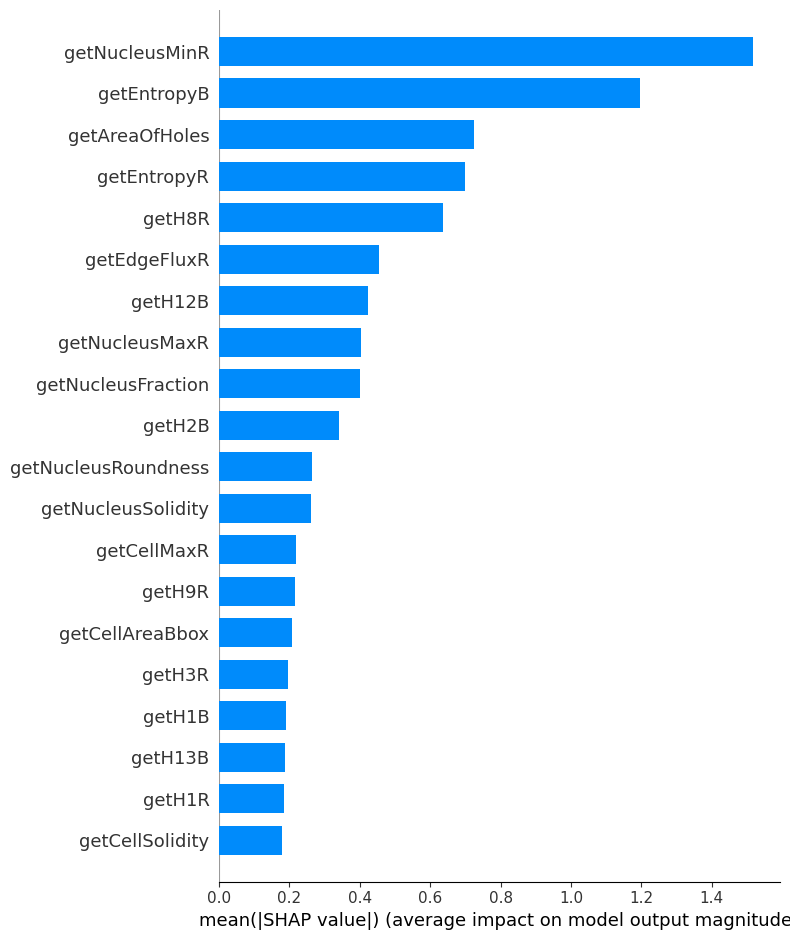

In [95]:
# Compute SHAP values
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)

# Visualize SHAP values
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type='bar')

In [96]:
###Hyperparameter tuning with Bayes search and cross-validation
# Define the search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', np.arange(3, 11, dtype=int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, 100, dtype=int)),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10)
}

# Objective function to minimize (log loss)
def objective(params):
    model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42, use_label_encoder=False, **params, n_jobs = -1)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss')
    return -np.mean(scores)

# Hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)

# Retrieve the best hyperparameters
best_params = space_eval(space, best)

# Train the final model with the best hyperparameters
best_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42, use_label_encoder=False, **best_params, n_jobs = -1)
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()

# Make predictions on the validation set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_proba.round())
conf_matrix = confusion_matrix(y_test, y_pred_proba.round())
logloss = log_loss(y_test, y_pred_proba)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Confusion matrix:", conf_matrix)
print("LogLoss:", logloss)

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 25/25 [01:07<00:00,  2.70s/trial, best loss: 0.4015844568975229] 
Best Hyperparameters: {'colsample_bytree': 0.7350917997184108, 'gamma': 0.8280212221932824, 'learning_rate': 0.011786618070918242, 'max_depth': 5, 'min_child_weight': 9.89305415417683, 'n_estimators': 700, 'subsample': 0.8112537223970759}
Accuracy: 0.8308823529411765
Confusion matrix: [[176  33]
 [ 36 163]]
LogLoss: 0.3531457820297453
Elapsed time: 0.8047523498535156 seconds


In [97]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

# Define the best model with the best hyperparameters
best_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42, use_label_encoder=False, **best_params, n_jobs=-1)

# Define KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store predictions and true labels
val_logloss_scores = []

# Loop through each fold
for train_index, val_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model on the training set
    best_model.fit(X_train, y_train)
    
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    # Predict probabilities on the validation set
    val_logloss = log_loss(y_test, y_pred_proba)
    val_logloss_scores.append(val_logloss)

mean_logloss = np.mean(val_logloss_scores)
print("Mean LogLoss from Cross-Validation:", mean_logloss)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
# print('Probabilities:',y_pred_proba)

Mean LogLoss from Cross-Validation: 0.3497515214772856


In [98]:
# import os
# import csv

# # Create a folder named 'solutions' if it doesn't exist
# folder_name = 'solutions'
# if not os.path.exists(folder_name):
#     os.makedirs(folder_name)

# Write = True
# if Write:
# # Your list of variables
#     top_20_features_list = top_20_features.tolist()
#     variables = top_20_features

#     # Path to the CSV file
    
#     csv_file_path = os.path.join(folder_name, 'Classification_GeorgiosSevastakis_XGBoost1_VariableList.csv')

#     # Open the CSV file in write mode
#     with open(csv_file_path, mode='w', newline='') as file:
#         # Create a CSV writer object
#         writer = csv.writer(file)

#         # Write each variable as a row in the CSV file
#         for variable in variables:
#             writer.writerow([variable])
    
#     data = y_pred_prob

#     # Path to the CSV file
#     csv_file_path = os.path.join(folder_name, 'Classification_GeorgiosSevastakis_XGBoost1.csv')
    
#     # Open the CSV file in write mode
#     with open(csv_file_path, mode='w', newline='') as file:
#         # Create a CSV writer object
#         writer = csv.writer(file)
        
#         # Enumerate through the data and write each item along with its index as a row in the CSV file
#         for index, item in enumerate(data, start=0):
#             writer.writerow([index, item])